# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it.

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
full_path='/content/drive/MyDrive/full.csv'

In [ ]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from keras.datasets import fashion_mnist
from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

In [ ]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Read Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/full.csv')

df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [ ]:
df['label'] = df['filename'].str.split('_').str[-2]

In [ ]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

Split and scale dataset

In [ ]:
columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy()

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

In [ ]:
X_train_scaled.shape

(127577, 77)

In [ ]:
def build_model(batch_size):
  ffn = models.Sequential()
  ffn.add(layers.Dense(units=128, activation='relu', input_shape=(77,)))
  ffn.add(layers.Dense(units=128, activation='relu'))
  ffn.add(layers.Dense(units=128, activation='relu'))
  ffn.add(layers.Dense(units=1, activation='sigmoid'))
  opt=optimizers.Adam()
  ffn.compile(
      optimizer=opt,
      loss='BinaryCrossentropy',
      metrics=['accuracy']
  )

  return ffn

In [ ]:
ffn=build_model(3)
ffn.build()
ffn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               9984      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 43,137
Trainable params: 43,137
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import KFold
from keras.callbacks import Callback
from timeit import default_timer as timer

In [ ]:
class TimingCallback(Callback):
  def __init__(self, logs={}):
    self.logs=[]
  def on_epoch_begin(self, epoch, logs={}):
    self.starttime = timer()
  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(timer()-self.starttime)

time = TimingCallback()

In [ ]:
batch_size1b=256
accuracy_dict1b={}
time_dict1b={}
no_epochs=100

# **Qn 1**
a. Use the training dataset to train the model for 100 epochs. Implement early stopping with patience 3.

In [ ]:
accuracies1b=[]
training_times1b=[]

stop_early = callbacks.EarlyStopping(
                            monitor='val_loss', patience=3)
checkpoint = callbacks.ModelCheckpoint(
                        'fnn_model.hdf5',
                        verbose=1,
                        save_best_only=True,
                        monitor='val_loss')
X_train, X_test = X_train_scaled, X_train_scaled
Y_train, Y_test = y_train, y_train
main_model = build_model(batch_size1b)
main_model.summary()
hist = main_model.fit(x=X_train,
                              y=Y_train,
                              validation_data=(X_test, Y_test),
                              epochs=no_epochs,
                              verbose=0,
                              callbacks=[stop_early, checkpoint, time])

accuracies1b.append(hist.history['accuracy'][-1])
training_times1b.append(time.logs[-1])
tf.keras.backend.clear_session()

accuracy_dict1b[f'{batch_size1b}'] = accuracies1b
time_dict1b[f'{batch_size1b}'] = training_times1b

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               9984      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 43,137
Trainable params: 43,137
Non-trainable params: 0
_________________________________________________________________

Epoch 1: val_loss improved from inf to 0.67785, saving model to fnn_model.hdf5

Epoch 2: val_loss improved from 0.67785 to 0.66439, saving model to fnn_model.hdf5

Epoch 3: val_loss

In [ ]:
accuracy_dict1b

{'256': [0.8854417204856873]}

In [ ]:
time_dict1b

{'256': [11.471040356000003]}

# **Qn 1**
b. Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots. Explain the use of early stopping in this question.

In [ ]:
hist.history['accuracy']
hist.history['val_accuracy']
hist.history['loss']
hist.history['val_loss']

[0.6784477829933167,
 0.6637735962867737,
 0.6427755355834961,
 0.6209833025932312,
 0.5976155996322632,
 0.5758463740348816,
 0.5563440918922424,
 0.5396587252616882,
 0.5191901326179504,
 0.501625657081604,
 0.4912107288837433,
 0.4772253632545471,
 0.47107788920402527,
 0.45020782947540283,
 0.4384983777999878,
 0.43398457765579224,
 0.42241019010543823,
 0.40760236978530884,
 0.40255776047706604,
 0.39877328276634216,
 0.38903942704200745,
 0.38291820883750916,
 0.37507718801498413,
 0.36307764053344727,
 0.36687541007995605,
 0.35716965794563293,
 0.34955132007598877,
 0.3447866141796112,
 0.342682808637619,
 0.33453643321990967,
 0.3240881860256195,
 0.32296890020370483,
 0.32148051261901855,
 0.30788061022758484,
 0.31364163756370544,
 0.305912047624588,
 0.3030003011226654,
 0.3027222156524658,
 0.29350149631500244,
 0.29099124670028687,
 0.2848329246044159,
 0.28033703565597534,
 0.2831023037433624,
 0.2718101143836975,
 0.2767130434513092,
 0.2677062451839447,
 0.263574182987

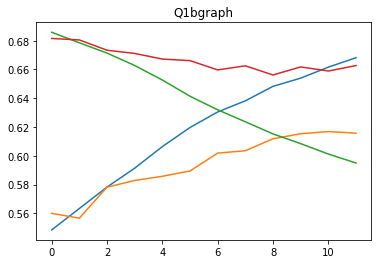

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Q1bgraph')
plt.show()

Early stopping is generally used to avoid over-fitting when the training model with iterative model is used, such as the adam optimiser for this method, and it would cause the model to have poor perfromance on the test set.

# **Qn 2**
a. Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch size [128, 256, 512, 1024].


In [ ]:
batch_size_list2a=[128,256, 512,1024]
accuracy_dict2a={}
time_dict2a={}

for batch_size in batch_size_list2a:
    kfold = KFold(n_splits=5)
    accuracies2a = []
    training_times2a = []
    for train_index, test_index in kfold.split(X_train_scaled):
        stop_early = callbacks.EarlyStopping(
                            monitor='val_loss', patience=3)
        checkpoint = callbacks.ModelCheckpoint(
                        'fnn_model.hdf5',
                        verbose=1,
                        save_best_only=True,
                        monitor='val_loss')
        X_train, X_test = X_train_scaled[train_index], X_train_scaled[test_index]
        Y_train, Y_test = y_train[train_index], y_train[test_index]
        main_model = build_model(batch_size)
        main_model.summary()
        hist = main_model.fit(x=X_train,
                              y=Y_train,
                              validation_data=(X_test, Y_test),
                              epochs=100,
                              verbose=0,
                              callbacks=[stop_early, checkpoint, time])

        accuracies2a.append(hist.history['accuracy'][-1])
        training_times2a.append(time.logs[-1])
        tf.keras.backend.clear_session()
    accuracy_dict2a[f'{batch_size}'] = accuracies2a
    time_dict2a[f'{batch_size}'] = training_times2a

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                4992      
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________

Epoch 1: val_loss improved from inf to 0.68178, saving model to fnn_model.hdf5

Epoch 2: val_loss improved from 0.68178 to 0.67780, saving model to fnn_model.hdf5

Epoch 3: val_loss

# **Qn 2**
b. Create a table of time taken to train the network on the last epoch against different batch sizes.

In [ ]:
time_dict2a

{'128': [6.241160135999962,
  6.219075796999732,
  6.665819216999807,
  6.201456933999907,
  6.536456800999986],
 '256': [6.2547914599999785,
  6.582779055999708,
  6.538427198000136,
  6.300850395999987,
  6.140822520999791],
 '512': [6.251279808000618,
  6.24473961700005,
  6.162585670000226,
  6.66569950199937,
  6.2778524109999125],
 '1024': [6.565698623000571,
  6.546746140000323,
  6.569552668000142,
  8.043977783999253,
  6.530082719999882]}

# **Qn 2**
c. Select the optimal batch size and state a reason for your selection.

In [ ]:
accuracy_dict2a

{'128': [0.6605559587478638,
  0.6843260526657104,
  0.6754423975944519,
  0.6675844192504883,
  0.6729341149330139],
 '256': [0.6777417659759521,
  0.6763896346092224,
  0.6562775373458862,
  0.6654484272003174,
  0.687993586063385],
 '512': [0.6798385381698608,
  0.6771930456161499,
  0.6852403283119202,
  0.6825655102729797,
  0.6705139875411987],
 '1024': [0.6826211810112,
  0.7021977305412292,
  0.6882287263870239,
  0.7037976980209351,
  0.6681820750236511]}

Batch size = 128, would be the optimal batch size, because it gives the highest accuracy.

# **Qn 2**
d. What happens when batch sizes increases & why?

The accuracy increases as the batch size increase, because, bigger batch size has less noise, and it offers better convergence as compared to a smaller batch size, but it is slower.

# **Qn 2**
e. Plot the train & test accuracies against epoch for the optimal batch size in a line plot.

<function matplotlib.pyplot.show(*args, **kw)>

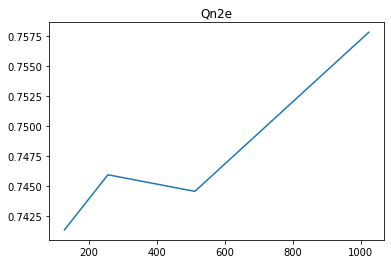

In [ ]:
optimal_bs=[128, 256, 512, 1024]
accuracies2e=[0.7413605451583862, 0.7459558248519897, 0.7445743083953857, 0.7578334808349609]
plt.plot(optimal_bs, accuracies2e)
plt.title('Qn2e')
plt.show

# **Qn 3**
a. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer usin g a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

Continue using the 5-fold cross validation on the training set.

In [ ]:
def build_model(hidden_layer):
  ffn = models.Sequential()
  ffn.add(layers.Dense(units=hidden_layer, activation='relu', input_shape=(77,)))
  ffn.add(layers.Dense(units=hidden_layer, activation='relu'))
  ffn.add(layers.Dense(units=hidden_layer, activation='relu'))
  ffn.add(layers.Dense(units=1, activation='sigmoid'))
  opt=optimizers.Adam()
  ffn.compile(
      optimizer=opt,
      loss='BinaryCrossentropy',
      metrics=['accuracy']
  )

  return ffn

In [ ]:
hidden_layer_list3a=[64, 128, 256]
accuracy_dict3a={}
time_dict3a={}

for hidden_layer in hidden_layer_list3a:
    kfold = KFold(n_splits=5)
    accuracies3a = []
    training_times3a = []
    for train_index, test_index in kfold.split(X_train_scaled):
        stop_early = callbacks.EarlyStopping(
                            monitor='val_loss', patience=3)
        checkpoint = callbacks.ModelCheckpoint(
                        'fnn_model.hdf5',
                        verbose=1,
                        save_best_only=True,
                        monitor='val_loss')
        X_train, X_test = X_train_scaled[train_index], X_train_scaled[test_index]
        Y_train, Y_test = y_train[train_index], y_train[test_index]
        main_model = build_model(hidden_layer)
        main_model.summary()
        hist = main_model.fit(x=X_train,
                              y=Y_train,
                              validation_data=(X_test, Y_test),
                              epochs=100,
                              verbose=0,
                              callbacks=[stop_early, checkpoint, time])

        accuracies3a.append(hist.history['accuracy'][-1])
        training_times3a.append(time.logs[-1])
        tf.keras.backend.clear_session()
    accuracy_dict3a[f'{hidden_layer}'] = accuracies3a
    time_dict3a[f'{hidden_layer}'] = training_times3a

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4992      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________

Epoch 1: val_loss improved from inf to 0.68239, saving model to fnn_model.hdf5

Epoch 2: val_loss improved from 0.68239 to 0.68087, saving model to fnn_model.hdf5

Epoch 3: val_loss i

# **Qn 3**
b. Select the optimal number of neuron for the hidden layer. State the rationale for your selection.

In [ ]:
accuracy_dict3a

{'64': [0.6775751709938049,
  0.6781434416770935,
  0.6674766540527344,
  0.6852011680603027,
  0.6537497043609619],
 '128': [0.7470826506614685,
  0.7435651421546936,
  0.7459877133369446,
  0.7295859456062317,
  0.7344555258750916],
 '256': [0.7845112085342407,
  0.7755950093269348,
  0.7352883815765381,
  0.7352393865585327,
  0.7705610394477844]}

In [ ]:
time_dict3a

{'64': [6.109505286000058,
  6.608463904999553,
  6.385693682999772,
  6.603643895999994,
  6.30213061700033],
 '128': [7.124527683999986,
  7.365507186000286,
  7.006144352999399,
  7.347017142999903,
  7.262694633000137],
 '256': [9.955329811999945,
  10.215213648999452,
  10.449435098999857,
  10.345238585000516,
  10.485745285000121]}

256 would the most the most optimal number of neurons for the hidden layer, because even tough 128 has the highest accuracy, but if we factor in the time taken as well as accuracy, it would be more optimal to select 256.

# **Qn 3**
c. Plot the train and test accuracies against the training epochs with the optimal number of neurons using a line plot.

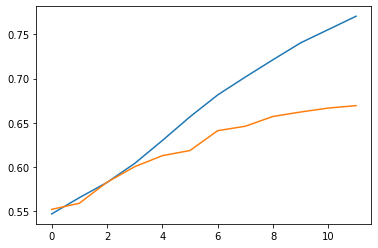

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

# **Qn 3**
d. How does the dropout work, and what is the purpose of dropouts?

Dropout is a regularization technique for neural network models where randomly selected neurons are ignored during the training, thus they are 'dropped out' randomly.

Thus, making their contribution to the activation of downstream neurons is temporarily removed on the forward pass, and any weight updates aren't applied on the backward pass.

Then, as the neural network learns, neuron weights settle into their context within the network. Weights od neurons are tuned for specific features, providing some specialisation.

After which, the neighbouring neurons come to rely on this specialisaton, which if taken too far, can result in a fragile model too specialise for the training data.

The effect is that the network becomes less sensitive to the specific weights of the neurons. This would then result ina network capable of better generalisation and less likely to overfit the training data.

# **Qn 3**
e. Besides early stopping and dropout, what is another approach that you could take to address overfitting in the model, and how does it work?

Implement the approach.

Ans: we can either use Regularisation or Normalisation.

Here we implement Normalisation.

In [ ]:
def build_model(hidden_layer):
  ffn = models.Sequential()
  ffn.add(layers.Dense(units=hidden_layer, activation='relu', input_shape=(77,)))
  ffn.add(layers.BatchNormalization())
  ffn.add(layers.Dense(units=hidden_layer, activation='relu'))
  ffn.add(layers.Dense(units=hidden_layer, activation='relu'))
  ffn.add(layers.Dense(units=1, activation='sigmoid'))
  opt=optimizers.Adam()
  ffn.compile(
      optimizer=opt,
      loss='BinaryCrossentropy',
      metrics=['accuracy']
  )

  return ffn

# **Qn 4**
a. Record yourself with a wav file for 5 seconds, either in a positive or negative manner. Preprocess the data using the preprocess script and prepare the data set.

In [ ]:
import librosa
import soundfile as sf

import numpy as np
import pandas as pd

import os
from os import listdir
from os.path import isfile, join

from collections import OrderedDict

import json

In [ ]:
def extract_features(filepath):

    '''
    Source: https://github.com/danz1ka19/Music-Emotion-Recognition/blob/master/Feature-Extraction.py
    Modified to process a single file

        function: extract_features
        input: path to mp3 files
        output: csv file containing features extracted

        This function reads the content in a directory and for each audio file detected
        reads the file and extracts relevant features using librosa library for audio
        signal processing
    '''

    feature_set = {}  # Features

    # Reading audio file
    y, sr = librosa.load(filepath)
    S = np.abs(librosa.stft(y, n_fft=512))
    # https://librosa.org/doc/main/generated/librosa.stft.html (set 512 for speech processing)

    # Extracting Features
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=512)

    chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512)
    rmse = librosa.feature.rms(y=y)[0]
    cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=512)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=512)
    contrast = librosa.feature.spectral_contrast(S=S, sr=sr, n_fft=512)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=512)
    poly_features = librosa.feature.poly_features(S=S, sr=sr, n_fft=512)

    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

    zcr = librosa.feature.zero_crossing_rate(y)
    harmonic = librosa.effects.harmonic(y)
    percussive = librosa.effects.percussive(y)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=512)
    mfcc_delta = librosa.feature.delta(mfcc)

    onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
    frames_to_time = librosa.frames_to_time(onset_frames[:20], sr=sr)

    # Concatenating Features into one csv and json format
    feature_set['filename'] = filepath  # song name
    feature_set['tempo'] = tempo  # tempo
    feature_set['total_beats'] = sum(beats)  # beats
    feature_set['average_beats'] = np.average(beats)
    feature_set['chroma_stft_mean'] = np.mean(chroma_stft)  # chroma stft
    feature_set['chroma_stft_var'] = np.var(chroma_stft)

    feature_set['chroma_cq_mean'] = np.mean(chroma_cq)  # chroma cq
    feature_set['chroma_cq_var'] = np.var(chroma_cq)

    feature_set['chroma_cens_mean'] = np.mean(chroma_cens)  # chroma cens
    feature_set['chroma_cens_var'] = np.var(chroma_cens)
    feature_set['melspectrogram_mean'] = np.mean(melspectrogram)  # melspectrogram
    feature_set['melspectrogram_var'] = np.var(melspectrogram)
    feature_set['mfcc_mean'] = np.mean(mfcc)  # mfcc
    feature_set['mfcc_var'] = np.var(mfcc)
    feature_set['mfcc_delta_mean'] = np.mean(mfcc_delta)  # mfcc delta
    feature_set['mfcc_delta_var'] = np.var(mfcc_delta)
    feature_set['rmse_mean'] = np.mean(rmse)  # rmse
    feature_set['rmse_var'] = np.var(rmse)
    feature_set['cent_mean'] = np.mean(cent)  # cent
    feature_set['cent_var'] = np.var(cent)
    feature_set['spec_bw_mean'] = np.mean(spec_bw)  # spectral bandwidth
    feature_set['spec_bw_var'] = np.var(spec_bw)
    feature_set['contrast_mean'] = np.mean(contrast)  # contrast
    feature_set['contrast_var'] = np.var(contrast)
    feature_set['rolloff_mean'] = np.mean(rolloff)  # rolloff
    feature_set['rolloff_var'] = np.mean(rolloff)
    feature_set['poly_mean'] = np.mean(poly_features)  # poly features
    feature_set['poly_var'] = np.mean(poly_features)

    feature_set['tonnetz_mean'] = np.mean(tonnetz)  # tonnetz
    feature_set['tonnetz_var'] = np.var(tonnetz)

    feature_set['zcr_mean'] = np.mean(zcr)  # zero crossing rate
    feature_set['zcr_var'] = np.var(zcr)
    feature_set['harm_mean'] = np.mean(harmonic)  # harmonic
    feature_set['harm_var'] = np.var(harmonic)
    feature_set['perc_mean'] = np.mean(percussive)  # percussive
    feature_set['perc_var'] = np.var(percussive)
    feature_set['frame_mean'] = np.mean(frames_to_time)  # frames
    feature_set['frame_var'] = np.var(frames_to_time)

    for ix, coeff in enumerate(mfcc):
        feature_set['mfcc' + str(ix) + '_mean'] = coeff.mean()
        feature_set['mfcc' + str(ix) + '_var'] = coeff.var()

    return feature_set

In [ ]:
new_features_dict = extract_features('/content/drive/MyDrive/Introduction.wav')
df1 = pd.DataFrame([new_features_dict])
df1.to_csv('./new_record.csv', index=False)

# **Qn 4**
b. Do a model prediction on your sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimised pretrained model using the selected optimal batch size and optimal number of neurons.

In [ ]:
best_model=models.load_model('/content/fnn_model.hdf5')

In [ ]:
df1.drop(labels='filename', axis = 1, inplace=True)

In [ ]:
df1.head()

,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,161.499023,1230,111.818182,0.695642,0.050151,0.402822,0.069577,0.247033,0.022308,0.221182,...,3.117354,66.570526,-6.447403,62.48204,1.576906,62.275311,-4.977098,46.403564,1.143298,57.712887


In [ ]:
predictions = best_model.predict(df1)

In [ ]:
predictions

array([[1.]], dtype=float32)

# **Qn 4**
c. Find the most important features on the model prediction for your test sample using SHAP. Plot the local feature importance with a force plot and explain your
observations

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
import keras.backend
shap.explainers._deep.deep_tf.op_handlers['AddV2'] = shap.explainers._deep.deep_tf.passthrough

shap_exp = shap.DeepExplainer(best_model, X_train_scaled)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


In [ ]:
shap_values = shap_exp.shap_values(X_test_scaled)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
shap.summary_plot(shap_values[0], plot_type='bar', feature_names=df1.columns)

In [ ]:
shap.decision_plot(shap_exp.expected_value[0].numpy(), shap_values[0][0], features = df1.iloc[0,:], feature_names = X_test.columns.tolist())

In [ ]:
shap.plots._waterfall.waterfall_legacy(shap_exp.expected_value[0].numpy(), shap_values[0][0], feature_names = X_test.columns)